# Neural Network Final Model

In [21]:
import pandas as pd
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../../')
import config

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [7]:
site = config.site
site_name = config.site_dict[site]
compound = config.compound

print(f"Exploring {compound} at {site_name}.")

Exploring ch2cl2 at Mace Head, Ireland.


### Loading & Initialising Data

In [8]:
data = pd.read_csv(data_path/'for_model.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_2_past,v500_3_past,v500_4_past,v500_5_past,v500_6_past,v500_7_past,v500_8_past,v500_13_past,v500_14_past,v500_15_past
1973,2001-06-10 23:15:00,1.0,2.710897,6.646357,3.520554,2.957919,1.400237,0.250116,-0.065496,-0.102276,...,-25.975510,-12.634301,0.170765,-8.678596,-14.625347,-15.324613,-20.165493,-2.279661,-10.631261,-12.954548
5448,2005-10-08 20:06:00,1.0,8.290799,8.785448,2.819069,7.967324,1.006440,3.331291,4.782045,9.697946,...,25.634113,32.698875,4.102418,2.460347,-5.772502,-7.920691,7.900711,-0.258228,-3.071601,-7.186419
5095,2005-07-03 19:41:00,1.0,5.050467,12.155300,2.280093,2.197175,4.723338,9.704673,8.656837,10.313497,...,21.191470,27.044703,15.005737,18.952227,-2.073123,-8.237114,-7.642454,5.835202,-8.646341,-17.480543
9351,2009-04-26 06:08:00,1.0,4.269832,2.075483,-0.461545,-0.554456,8.234962,5.375477,6.924912,11.349134,...,19.321552,2.189260,11.361387,-5.848471,-23.475245,-23.439693,-23.391214,-0.767927,-27.932032,-32.716854
12488,2012-04-26 15:41:00,1.0,0.337694,-3.772571,-2.015186,-0.287575,7.589193,1.096950,-1.859545,-2.087592,...,-2.631880,-3.410871,-9.049419,-19.915829,-17.663626,-12.868374,-6.184838,-13.569904,-6.469835,-18.075775


In [9]:
if compound == 'ch2cl2':
    train_data = data[(data['time'].dt.year >= 2010) & (data['time'].dt.year <= 2012)]
    val_data = data[(data['time'].dt.year >= 2013) & (data['time'].dt.year <= 2013)]
    test_data = data[(data['time'].dt.year >= 2014) & (data['time'].dt.year <= 2016)]

else:
    train_data = data[(data['time'].dt.year >= 2016) & (data['time'].dt.year <= 2018)]
    val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
    test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")

# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])


# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']


# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2010-01-02 04:02:00 -> 2012-12-31 22:29:00. Length: 3295
Val range: 2013-01-01 00:29:00 -> 2013-12-30 09:25:00. Length: 847
Test range: 2014-01-02 20:09:00 -> 2016-12-31 21:51:00. Length: 3285


### Model

In [10]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.05, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

y_pred_val = nn_model.predict(X_val)
y_pred_train = nn_model.predict(X_train)


precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Testing Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Testing Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Testing Set = {f1_val:.3f}")

Precision on Training Set = 0.869
Precision on Testing Set = 0.887
Recall on Training Set = 0.967
Recall on Testing Set = 0.974
F1 Score on Training Set = 0.915
F1 Score on Testing Set = 0.929


In [46]:
# evaluating model on test set

y_pred_test = nn_model.predict(X_test)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")

Precision on Testing Set = 0.885
Recall on Testing Set = 0.972
F1 Score on Testing Set = 0.926


In [43]:
# finding most important features in the model using permutation importance
# using the testing set
perm_importance = permutation_importance(nn_model, X_train, y_train, n_repeats=30, random_state=42)
sorted_importances = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance (Testing Set)')

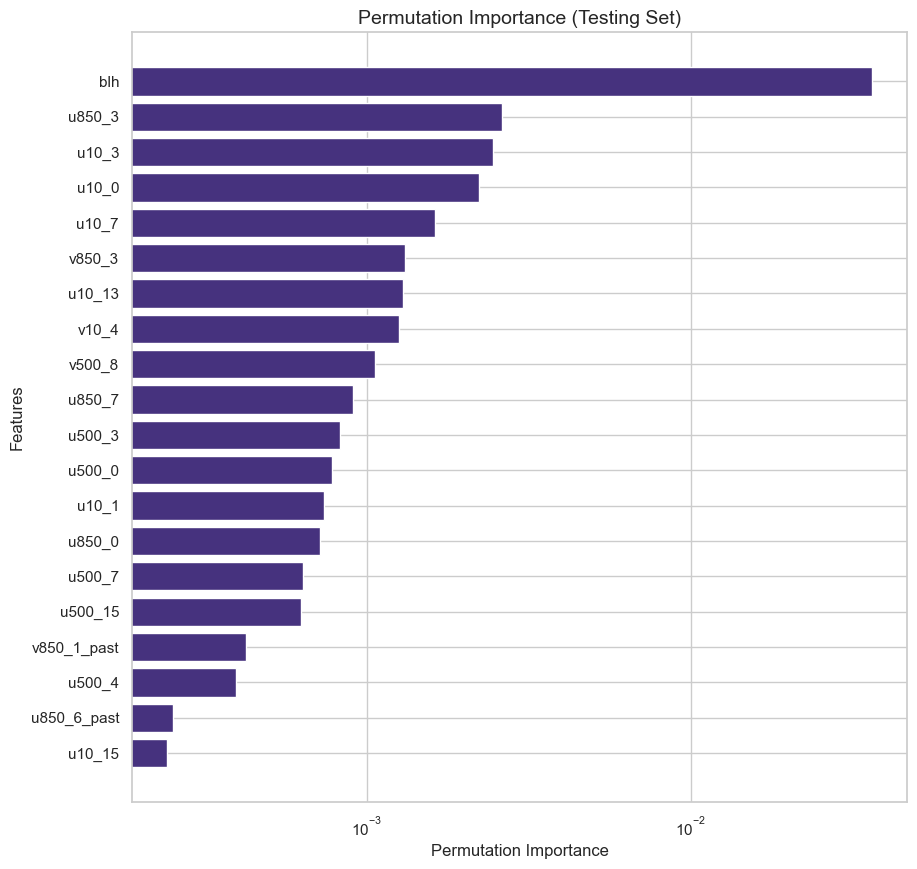

In [45]:
# plotting first 20 most important features in a histogram

fig, ax = plt.subplots(figsize=(10, 10))
sns.set(style="whitegrid")
sns.set_palette("viridis")

ax.barh(X_val.columns[sorted_importances][-20:], perm_importance.importances_mean[sorted_importances][-20:])

ax.set_xscale('log')

ax.set_ylabel('Features')
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance (Testing Set)', fontsize=14)

In [47]:
# saving the model

dump(nn_model, data_path/'nn_model.joblib')

['C:\\Users\\kirst\\OneDrive\\Kirstin\\Uni\\Year4\\MSciProject\\data_files\\saved_files\\nn_model.joblib']